<a href="https://colab.research.google.com/github/ruval195/Pattern_Recognition/blob/main/Final_Proyect_Pattern_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimeinto de Patrones
## Diego Francisco Ruvalcaba Loredo
## Proyecto Final
### "En un reciente viaje al extranjero tuve varias actividades al aire libre, tenia que estar muy pendiente al clima, investigue como antes por medio de la estadistica y analisis de patrones funcionaba los reportes meteorlogicos, por lo mismo este proyecto analizara una base de datos de 10 años de datos meteorologico de una ciudad en Australia analizando y entrenando un algoritmo de IA"


## Librerias

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time


# Cargar datos
!wget 'https://raw.githubusercontent.com/ruval195/Pattern_Recognition/refs/heads/main/Data_set_ha/weatherAUS.csv'
df = pd.read_csv('weatherAUS.csv')
df.head()


--2025-04-28 02:44:33--  https://raw.githubusercontent.com/ruval195/Pattern_Recognition/refs/heads/main/Data_set_ha/weatherAUS.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14094055 (13M) [text/plain]
Saving to: ‘weatherAUS.csv’

weatherAUS.csv      100%[===================>]  13.44M  --.-KB/s    in 0.1s    

2025-04-28 02:44:33 (118 MB/s) - ‘weatherAUS.csv’ saved [14094055/14094055]



,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Preprocesamiento de datos

In [3]:
df = df.sample(50000, random_state=42)

# Eliminamos columnas inecesarias
df = df.drop(['Date', 'Location'], axis=1)

# Quitamos los N/A
df = df.dropna()
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Dividimos columnas numéricas y categóricas para procesarlas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocesacion
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Busqueda de mejore hiperparámetros SVC

In [4]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('svm', SVC(kernel='rbf', probability=True))
])

# Parametros a testear
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01, 0.1]
}
grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
start = time.time()
grid.fit(X_train, y_train)
end = time.time()
print(f"Mejores parámetros para SVM:{grid.best_params_} en {end - start} seg")

Mejores parámetros para SVM:{'svm__C': 1, 'svm__gamma': 0.1} en 1837.703188419342 seg


## Entrenamiento de modelos

In [5]:
modelos = {
    'SVM': Pipeline([
        ('prep', preprocessor),
        ('model', SVC(
            kernel='rbf',
            probability=True,
            C=grid.best_params_['svm__C'],
            gamma=grid.best_params_['svm__gamma']
        ))
    ]),
    'MLPClassifier': Pipeline([
        ('prep', preprocessor),
        ('model', MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=300,
            random_state=42
        ))
    ]),
    'HistGradientBoosting': Pipeline([
        ('prep', preprocessor),
        ('model', HistGradientBoostingClassifier(random_state=42))
    ])
}


## Evaluacion de los modelos

Resultados para SVM:
Accuracy : 0.8552
Precision: 0.7496
Recall   : 0.5456
F1-score : 0.6315

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Lluvia       0.88      0.95      0.91      2982
      Lluvia       0.75      0.55      0.63       878

    accuracy                           0.86      3860
   macro avg       0.81      0.75      0.77      3860
weighted avg       0.85      0.86      0.85      3860

Matriz de confusión:
 [[2822  160]
 [ 399  479]]


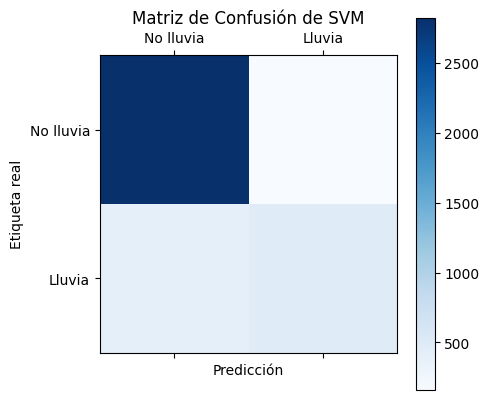

Resultados para MLPClassifier:
Accuracy : 0.8256
Precision: 0.6258
Recall   : 0.5809
F1-score : 0.6025

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Lluvia       0.88      0.90      0.89      2982
      Lluvia       0.63      0.58      0.60       878

    accuracy                           0.83      3860
   macro avg       0.75      0.74      0.75      3860
weighted avg       0.82      0.83      0.82      3860

Matriz de confusión:
 [[2677  305]
 [ 368  510]]


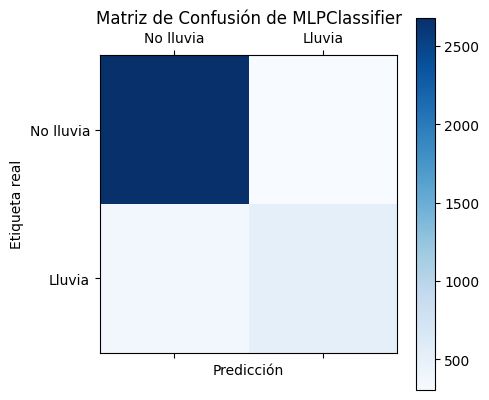

Resultados para HistGradientBoosting:
Accuracy : 0.8536
Precision: 0.7332
Recall   : 0.5604
F1-score : 0.6352

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Lluvia       0.88      0.94      0.91      2982
      Lluvia       0.73      0.56      0.64       878

    accuracy                           0.85      3860
   macro avg       0.81      0.75      0.77      3860
weighted avg       0.85      0.85      0.85      3860

Matriz de confusión:
 [[2803  179]
 [ 386  492]]


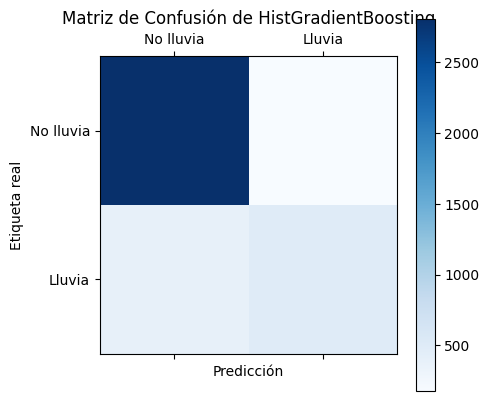

In [6]:
resultados = {}
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados[nombre] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}

    # Reportes
    print(f"Resultados para {nombre}:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=['No Lluvia', 'Lluvia']))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n", cm)

    # Gráfico
    plt.matshow(cm, cmap='Blues')
    plt.title(f"Matriz de Confusión de {nombre}")
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta real')
    plt.xticks([0,1], ['No lluvia', 'Lluvia'])
    plt.yticks([0,1], ['No lluvia', 'Lluvia'])
    plt.colorbar()
    plt.show()

## Tabla comparativa de los modelos

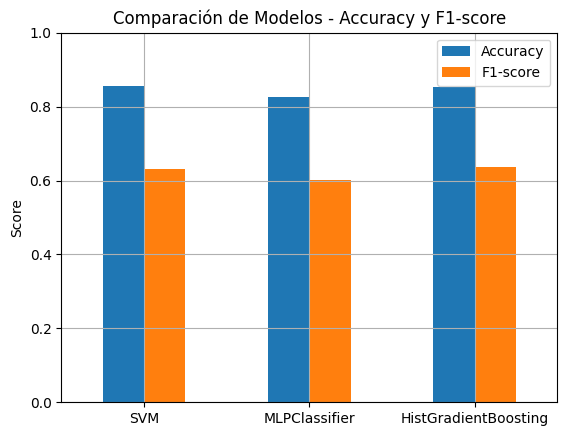

In [7]:
resultados_df = pd.DataFrame(resultados).T

resultados_df[['Accuracy', 'F1-score']].plot(kind='bar')
plt.title('Comparación de Modelos - Accuracy y F1-score')
plt.ylabel('Score')
plt.ylim(0,1)
plt.grid(True)
plt.xticks(rotation=0)
plt.show()